In [30]:
import pandas as pd
import matplotlib.pyplot as plt



In [31]:
df = pd.read_csv("normalized_NO_missing_1498_6.csv")

In [32]:
def outliers_function(data, column, factor):
    col = pd.to_numeric(data[column]).astype(float)

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    lower_15 = Q1 - 1.5 * IQR
    upper_15 = Q3 + 1.5 * IQR
    lower_3 = Q1 - 3 * IQR
    upper_3 = Q3 + 3 * IQR

    if factor == 3:  # ekstremalios isskirtys
        out = col[(col < lower_3) | (col > upper_3)]
    elif factor == 1.5:  # salygines isskirtys
        out = col[((col < lower_15) & (col >= lower_3)) |
                  ((col > upper_15) & (col <= upper_3))]
    else:
        out = pd.Series(dtype=float)
    return out.index


feature_columns = [c for c in df.columns if c != 'label']

conditional_outliers = set()
extreme_outliers = set()

for col in feature_columns:
    cond_idx = outliers_function(df, col, 1.5)
    extr_idx = outliers_function(df, col, 3)
    conditional_outliers.update(cond_idx)
    extreme_outliers.update(extr_idx)


df['outlier'] = df['label']

# salygines
df.loc[df.index.isin(conditional_outliers), 'outlier'] = 3

# ekstremalios
df.loc[df.index.isin(extreme_outliers), 'outlier'] = 4


X = df.drop(columns=['label', 'outlier']).values
y_class = df['label'].values
y_group = df['outlier'].values

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,         # sumažiname duomenų dimensijų skaičių iki 2
    perplexity=30,          # kiek artimiausių kaimynų laikoma reikšmingais
    learning_rate=200,      # nustato, kokio dydžio korekcijos taikomos kiekviename iteracijos žingsnyje
    n_iter=1000,            # iteracijų skaičius: kiek gradientinio nusileidimo žingsnių atliekama minimizuojant klaidą
    early_exaggeration=12.0,# padeda atskirti klasterius ir išvengti lokalių minimumų
    metric="euclidean",     # atstumo metrika pradinėje erdvėje
    random_state=67,        # kad rezultatai būtų atkuriami (užtikrina tą pačią pradinę taškų padėtį)
    init="pca"              # pradinė taškų pozicija nustatoma PCA pagrindu (stabiliau nei random)
)

X_tsne = tsne.fit_transform(X)


/Users/robertajurpalyte/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


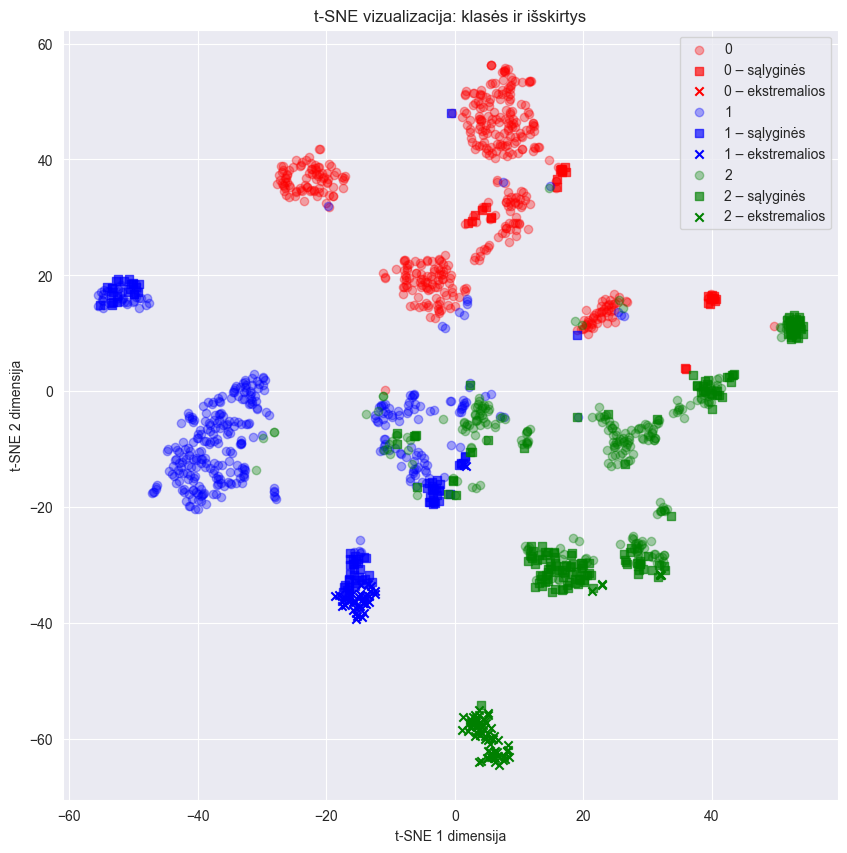

In [29]:
colors = ['red', 'blue', 'green']
class_labels = ['0', '1', '2']
markers = {
    'normal': 'o',
    'conditional': 's',
    'extreme': 'x'
}

plt.figure(figsize=(10, 10))

for i, color in enumerate(colors):
    # normalūs
    plt.scatter(
        X_tsne[(y_class == i) & (y_group == i), 0],
        X_tsne[(y_class == i) & (y_group == i), 1],
        color=color,
        marker=markers['normal'],
        label=class_labels[i],
        alpha=0.33,
    )
    # sąlyginės
    plt.scatter(
        X_tsne[(y_class == i) & (y_group == 3), 0],
        X_tsne[(y_class == i) & (y_group == 3), 1],
        color=color,
        marker=markers['conditional'],
        label=f"{class_labels[i]} – sąlyginės",
        alpha=0.66,
    )
    # ekstremalios
    plt.scatter(
        X_tsne[(y_class == i) & (y_group == 4), 0],
        X_tsne[(y_class == i) & (y_group == 4), 1],
        color=color,
        marker=markers['extreme'],
        label=f"{class_labels[i]} – ekstremalios",
        alpha=1,
    )

plt.title("t-SNE vizualizacija: klasės ir išskirtys")
plt.xlabel("t-SNE 1 dimensija")
plt.ylabel("t-SNE 2 dimensija")
plt.legend()
plt.grid(True)
plt.show()